### Libraries

In [18]:
import SR_lib as sr 
from gen_time_ser_data import *
from analysis_data import *

import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import re

### Functions

In [2]:
def find_alpha_beta(Vc, Pr, tf):
    Ec= Vc/tf
    alpha = -3*np.sqrt(3)*Ec/4/Pr
    beta = 3*np.sqrt(3)*Ec/8/(Pr**3)
    print(f"VC = {Vc} V")
    print(f"Ec = {Ec*1e-5:.2e} kV/cm")
    print(f"Pr = {Pr*10} uC/cm^2")
    print(f"Landau coeff, alpha = {alpha:.2e} mF^-1, beta = {beta:.2e} m^5F^-1C^-1")
    return alpha, beta

def sd2Dext_delF(sd, rho, bw, tf, delF):
    Dext_delF = (sd**2)/(2*rho*bw*tf**2*delF)
    return Dext_delF

def Dext_delF2sd(Dext_delF, rho, bw, tf, delF):
    sd = np.sqrt(Dext_delF*2*rho*bw*tf**2*delF)
    return sd

In [3]:
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data_section = False
    column_data = []
    
    for line in lines:
        if "Data" in line:
            data_section = True
            continue
        
        if data_section:
            values = re.split(r'\s+', line.strip())
            if len(values) >= 8 and values[0].isdigit():  # Ensure valid data row
                column_data.append([float(v) for v in values])
    
    # Transpose the data to get lists for each column
    columns = list(map(list, zip(*column_data)))
    return columns

def find_Ec_Pr(P,E):
    #find the zero crossing points for P
    idx1 = np.where(np.abs(P[0:int(len(P)/2)]) == np.min(np.abs(P[0:int(len(P)/2)])))
    idx2 = np.where(np.abs(P[int(len(P)/2):int(len(P))]) == np.min(np.abs(P[int(len(P)/2):int(len(P))])))
    Ec1 = E[idx1[0][0]]
    Ec2 = E[int(len(E)/2)-1 + idx2[0][0]]
    #find the zero crossing points for E
    idx2 = np.where(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10]) == np.min(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10])))
    Pr1 = P[0]
    Pr2 = P[int(len(E)/2)-10 + idx2[0][0]]
    return Ec1, Ec2, Pr1, Pr2

def TDGL(t, Pint, E, alpha, beta, rho):
    P_fit = [Pint]
    dt = t[1] - t[0]
    for i in range(1,len(t)):
        df_dp = 2*alpha*P_fit[i-1] + 4*beta*P_fit[i-1]**3 - E[i]
        P_fit.append(P_fit[i-1] - dt/rho*df_dp)
    return P_fit

#generating sine wave
def sin_wave(M, frequency, dt):
    T = 1 / frequency  # Period of the wave
    t = np.arange(0, 2*T, dt)  # Time values
    # Generate triangular wave: 0 → +max → -max → 0
    y =  M*np.sin(2*np.pi*t*frequency)
    return t, y

In [4]:
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_section = False
    column_data = []
    for line in lines:
        if "Data" in line:
            data_section = True
            continue
        if data_section:
            values = re.split(r'\s+', line.strip())
            if len(values) >= 8 and values[0].isdigit():  # Ensure valid data row
                column_data.append([float(v) for v in values])
    # Transpose the data to get lists for each column
    columns = list(map(list, zip(*column_data)))
    return columns

def SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70):
    Vc = params.get('Vc')
    Pr = params.get('Pr')
    alpha = params.get('alpha')
    beta = params.get('beta')
    rho = params.get('rho')
    tf = params.get('tf')
    Af = params.get('Af')
    T = params.get('T')
    Asig = params.get('A')
    fsig = params.get('f')
    sd = params.get('sd')
    ts = params.get('ts')
    n = params.get('n')
    ens = params.get('ens')
    dsf = params.get('dsf')  # Downsampling factor
    bw = params.get('bw') 

    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[0]:.2f}_ens{0}.txt')
    E0 = Edrive
    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{Vc*1.5}V_sd{sd[0]:.2f}_ens{0}.txt')
    Pswitch = P
    for i in range(len(sd)):
        Cov_ens = 0
        psd_ens = 0
        psd_noise_ens = 0
        for e in range(ens):
            t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[i]:.2f}_ens{e}.txt')
            Cov_ens += np.cov(P,Pswitch)[1,0]    
            freq, psd = sr.signal_psd(P, f, 1/(dsf*ts), delw)
            freq, psd_noise = sr.signal_psd((Edrive - E0)*tf, f, 1/(dsf*ts), delw)
            psd_ens += psd
            psd_noise_ens += psd_noise

        P_ens, NF_ens, SNR_ens = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)
        # P_ens, NF_ens, SNR_ens, _, _ = sr.power_snr_noisefloor(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)

        ffro = int(2*len(freq)/ (1/(dsf*ts))*(f - delw_noise)) + 1
        fto = int(2*len(freq)/ (1/(dsf*ts))*(f + delw_noise)) + 1
        
        PSD.append(psd_ens/ens)
        PSR.append(P_ens)
        NF.append(NF_ens)
        SNR.append(SNR_ens)
        COV.append(Cov_ens/ens)
        sd_crt.append(sr.sd_correction(Edrive*tf,E0*tf))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw_crt, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

    

def SR_matric_exp_IITPKD(sd, ens, Pswitch, bw, f, alpha, beta, rho, tf, Af, raw_data_file, delw =5 , delw_noise = 70):
        PSD = []
        PSR = []
        NF = []
        SNR = []
        COV = []
        sd_crt = []
        bw_crt = []
        fro = 250
        tdrive, Vdrive, _ = sr.extract_tEP_data(raw_data_file + f"\\data_sd_{sd[0]}_itr{0}.txt")
        V0 =  Vdrive[fro:]
        ts = (tdrive[1] - tdrive[0])*1e-3
        for i in range(len(sd)):
            Cov_ens = 0
            psd_ens = 0
            psd_noise_ens = 0
            for e in range(ens):
                if(i == 0): # this is an adjustment to account for only 1 ensemble for the 0 sd
                    e = 0
                if((i == 13) & (e == 9)):
                    e = 8  # this is an adjustment 
                tdrive, Vdrive, P = sr.extract_tEP_data(raw_data_file + f"\\data_sd_{sd[i]}_itr{e}.txt")
                Vdrive = Vdrive[fro:]
                P = P[fro:]
                Cov_ens += np.cov(P,Pswitch)[1,0]    
                freq, psd = sr.signal_psd(P, f, 1/ts, delw)
                freq, psd_noise = sr.signal_psd(Vdrive - V0, f, 1/ts, delw)
                psd_ens += psd
                psd_noise_ens += psd_noise

            Pwr, Nf, Snr = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens, f,  1/ts, delw, delw_noise)
            PSD.append(psd_ens/ens)
            PSR.append(Pwr)
            NF.append(Nf)
            SNR.append(Snr)
            COV.append(Cov_ens/ens)
            sd_crt.append(sr.sd_correction(Vdrive,V0))
            bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

        sd_crt = np.array(sd_crt)
        bw_crt = np.array(bw_crt)
        Dext_delF = sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af)
        Dext_delF_crt = sr.Dext_delF(sd_crt, bw, alpha, beta, rho, tf, Af)
        return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

### Parameters

In [5]:
# Sample IITPKD
Vc = 1.7
Pr = 0.161
tf = 255e-9
Af = 1000e-12
rho = 390
bw = 10e4
tf = 255e-9
alpha , beta = find_alpha_beta(Vc, Pr, tf)
delF = sr.del_U(0, alpha, beta, tf)[0]
print(f"barrier height = {sr.del_U(0, alpha, beta, tf)[0]:.2e}")
sd_val = 5
print(f"sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 4
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 1.7 V
Ec = 6.67e+01 kV/cm
Pr = 1.61 uC/cm^2
Landau coeff, alpha = -5.38e+07 mF^-1, beta = 1.04e+09 m^5F^-1C^-1
barrier height = 6.97e+05
sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 7.070311254459822
 Dext_delF to sd convertion: Dext_DelF = 4 -> sd = 3.7608042890388274


In [6]:
## Read the Parse file
params_path = 'sim_7\\parameters.txt'  # Parse input file
params = sr.read_simulation_parameters(params_path)
## Create the simulation directory
id = params.get('id')
output_dir = f'sim_{id}'
os.makedirs(output_dir, exist_ok=True)
raw_data_file = os.path.join(output_dir, "raw_data")

### Hysteresis and Fit

In [7]:
# f_s = [1, 10, 100, 1000]

# plt.figure(figsize=(15,10))
# for i, f in enumerate(f_s):
#     #read the data 1hz standard bipolar (the measurement after Ktime)
#     data_columns = extract_data(f"IITPKD_data\\post_Hysteresis{f}Hz.txt")
#     time, V_drive, P, _, _, _, _ = data_columns[1:]
#     time = np.array(time)*1e-3
#     P = np.array(P)*1e-2
#     dt = time[1] - time[0]
#     Vc1, Vc2, Pr1, Pr2 = find_Ec_Pr(P,V_drive)
#     V_drive = np.array(V_drive)
#     V_drive = V_drive - (Vc1 + Vc2)/2

#     dt = 1000e-9
#     t, Edrive = sin_wave(7/tf, f, dt)
#     P_fit =TDGL(t, -0.16 , Edrive, alpha, beta, rho)
#     # plt.subplot(2,2,i+1)
#     plt.plot(V_drive, P, label = f"Experiment (f = {f} Hz)")
#     plt.ylim([-0.4, 0.4])

#     plt.plot(Edrive*tf, P_fit,"--", c = 'black', label = f"Numerical fit (f = {f} Hz)")
#     plt.ylabel("P (C/m2)")
#     plt.xlabel("V (V)")
#     plt.legend()
#     plt.grid()
#     plt.tick_params(axis='both', direction='in', top=True, right=True  )

#     # plt.title(f"alpha = {alpha:.2}, beta = {beta:.2}, rho = {rho} (range)")
#     plt.title(f"f = {f} Hz")



In [8]:
#read the data 1hz standard bipolar (the measurement after Ktime)
data_columns = extract_data(f"IITPKD_data\\post_Hysteresis1Hz.txt")
time, V_drive, P, _, _, _, _ = data_columns[1:]
time = np.array(time)*1e-3
P = np.array(P)*1e-2
dt = time[1] - time[0]
Vc1, Vc2, Pr1, Pr2 = find_Ec_Pr(P,V_drive)
V_drive = np.array(V_drive)
V_drive = V_drive - (Vc1 + Vc2)/2

#read the data 10hz standard bipolar (fresh sample measurement)
data_columns = extract_data(f"IITPKD_data\\Hysteresis10Hz.txt")
time_fresh, V_drive_fresh, P_fresh, _, _, _, _ = data_columns[1:]
time_fresh = np.array(time_fresh)*1e-3
P_fresh = np.array(P_fresh)*1e-2
dt_fresh = time_fresh[1] - time_fresh[0]
Vc1_fresh, Vc2_fresh, Pr1, Pr2 = find_Ec_Pr(P_fresh,V_drive_fresh)
V_drive_fresh = np.array(V_drive_fresh)
V_drive_fresh = V_drive_fresh - (Vc1_fresh + Vc2_fresh)/2

# the PUND data from IITPKD sample
with open("IITPKD_data\\Remanent_Hyst_1Hz.txt", 'r') as file:
    lines = file.readlines()
    
    data_section = False
    column_data = []
    
    for line in lines:
        values = re.split(r'\s+', line.strip())
        if len(values) >= 6 and values[0].isdigit():  # Ensure valid data row
            column_data.append([float(v) for v in values])
    
    # Transpose the data to get lists for each column
    columns = list(map(list, zip(*column_data)))

time_PUND = np.array(columns[1])*1e-3
voltage_PUND = np.array(columns[2])
polarization_PUND = np.array(columns[5])*1e-2
Vc_PUND1, Vc_PUND2,_, _ = find_Ec_Pr(polarization_PUND, voltage_PUND)
voltage_PUND = voltage_PUND - (Vc_PUND1 + Vc_PUND2)/2

In [9]:
# alpha = -4.77e7
# beta = 5.82e8
# rho = 390
dt = 1000e-9
t, Edrive = sin_wave(7/tf, 1, dt)
P_fit =TDGL(t, -0.16 , Edrive, alpha, beta, rho)

Text(0.5, 1.0, 'Polarization vs Time (IITPKD sample)')

C:\Users\manik\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\manik\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


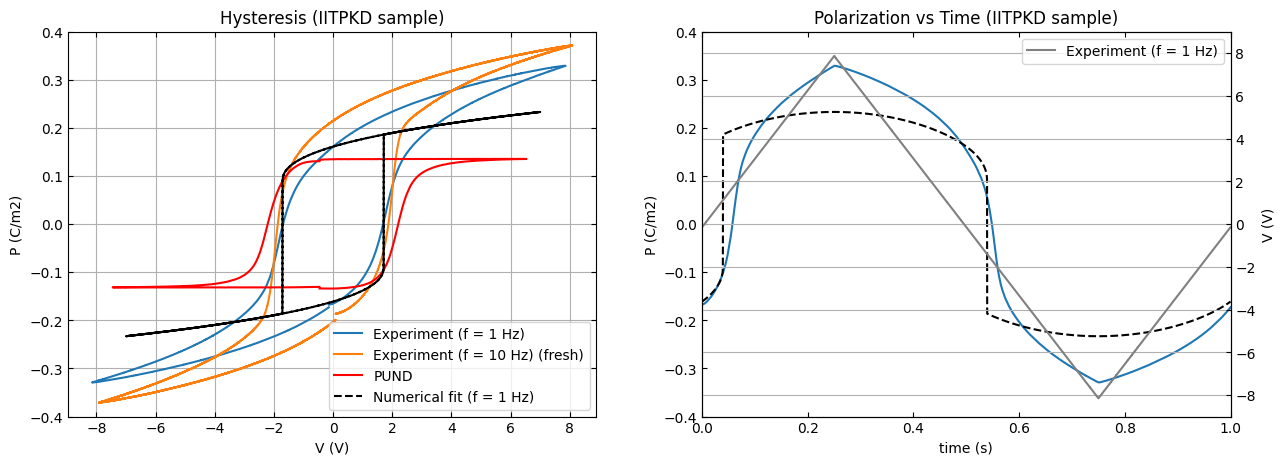

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(V_drive, P, label = f"Experiment (f = 1 Hz)")
plt.plot(V_drive_fresh, P_fresh, label = f"Experiment (f = 10 Hz) (fresh)")
plt.plot(voltage_PUND, polarization_PUND, label = f"PUND", c = "red")
plt.ylim([-0.4, 0.4])

# plt.plot(V_drive_post/tf, P_post, label = f"f = {f_data[2]} Hz post")
plt.plot(Edrive*tf, P_fit,"--", c = 'black', label = "Numerical fit (f = 1 Hz)")
plt.ylabel("P (C/m2)")
plt.xlabel("V (V)")
plt.legend()
plt.grid()
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.title(f"alpha = {alpha:.2}, beta = {beta:.2}, rho = {rho} (range)")
plt.title("Hysteresis (IITPKD sample)")

ax1 = plt.subplot(1,2,2)
ax1.plot(time, P, label = f"Experiment (f = 1 Hz)")
# plt.plot(time_post, P_post, label = f"f = {f_data[2]} Hz post")
ax1.plot(t[0:int(len(t)/2)], P_fit[0:int(len(t)/2)],"--", c = 'black', label = "Numerical fit (f = 1 Hz)")
ax1.set_ylim([-0.4, 0.4])
ax1.set_xlim([0, 1])
ax1.set_xlabel("time (s)")
ax1.set_ylabel("P (C/m2)")
ax1.tick_params(axis='both', direction='in', top=True, right=True  )

ax2 = ax1.twinx()
ax2.plot(time, V_drive, label = f"Experiment (f = 1 Hz)", c = "grey")
ax2.set_ylim([-9, 9])
ax2.set_ylabel("V (V)")
ax2.tick_params(axis='both', direction='in', top=True, right=True  )

ax2.legend()
plt.grid()
plt.title("Polarization vs Time (IITPKD sample)")
# plt.savefig("fig//IITPKD_PV_hyst_P_t_data.pdf")

### Simulation

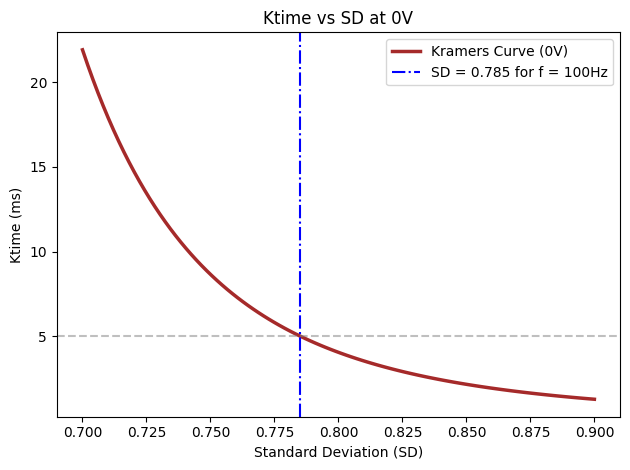

In [11]:
# Kramers' Time
sd_range = np.linspace(0.7,0.9,100)
Ktime = sr.calculate_kramer_curve(sd_range, 0, alpha, beta, rho, bw, tf, Af)

# Plot the curve
plt.plot(sd_range, Ktime*1e3, linewidth = 2.5, color = "brown", label='Kramers Curve (0V)')
c = ["blue", "black", "red"]
# Target Ktime in ms
fsig = [100]
sd_opt_f = []
for i, f in enumerate(fsig):
    target_time = 1/(2*f)
    interp_fn = interp1d(Ktime, sd_range, bounds_error=False, fill_value="extrapolate")
    sd_opt = interp_fn(target_time)
    sd_opt_f.append(sd_opt)
    Dext_delF_opt = sr.Dext_delF(sd_opt, bw, alpha, beta, rho, tf, Af)[0]
    # Draw horizontal line at target time
    plt.axhline(y=target_time*1e3, color='gray', linestyle='--', alpha = 0.5)
    # Draw vertical line at corresponding SD
    plt.axvline(x=sd_opt, color=c[i], linestyle='-.', label=f'SD = {sd_opt:.3f} for f = {f}Hz')
# Axis labels and title
plt.xlabel('Standard Deviation (SD)')
plt.ylabel('Ktime (ms)')
plt.title('Ktime vs SD at 0V')
plt.legend()
# plt.grid(True)
plt.tight_layout()
# plt.savefig("Ktime_0bias.pdf")

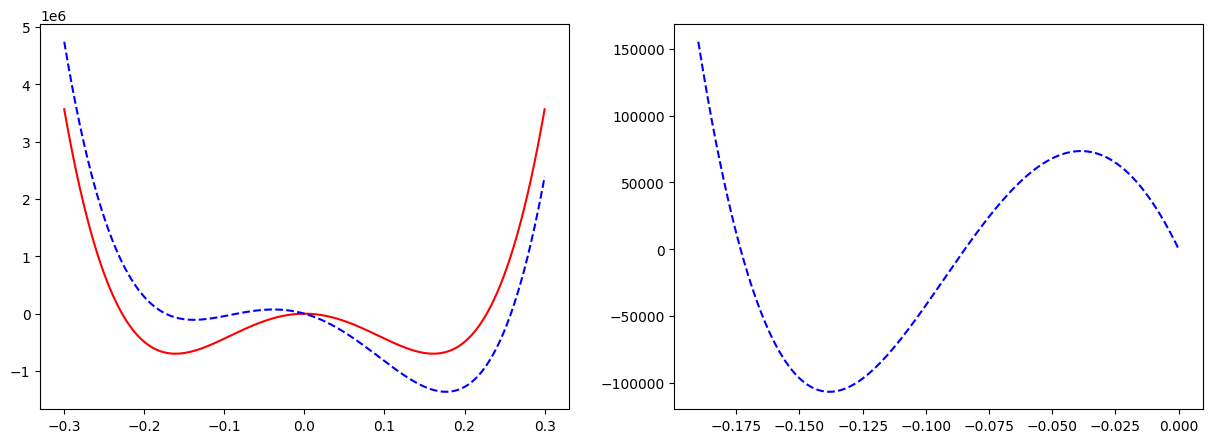

In [12]:
# ploting the doubel well

P_x = np.linspace(-0.3, 0.3, 1000)
bias = 0
U0 = sr.U(P_x, bias, alpha, beta, tf)
bias = 1
U1 = sr.U(P_x, bias, alpha, beta, tf)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(P_x, U0, c = "red")
plt.plot(P_x, U1, "--", c ="blue")

P_x = np.linspace(-0.19, 0, 1000)
bias = 1
U1 = sr.U(P_x, bias, alpha, beta, tf)

plt.subplot(1,2,2)
# plt.plot(P_x, U0)
plt.plot(P_x, U1, "--", c ="blue")

plt.savefig("Doublewell_bias.pdf")

In [44]:
# SR matrics
Asig = params.get('A')
fsig = params.get('f')

Dext_DelF_opt = sd2Dext_delF(np.array(sd_opt_f), rho, bw, tf, delF)
plt.figure(figsize=(20,5))
for i in range(len(fsig)):
    f = fsig[i]
    A = Asig[0]
    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)

<Figure size 2000x500 with 0 Axes>

In [14]:
## plotting just the 
# clr = ["blue"]
# styl = ["-s"]
# i = 0
# plt.figure(figsize=(5,15))
# plt.subplot(3,1,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.ylim([0, 0.03]); plt.legend()
# plt.subplot(3,1,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$"); plt.ylim([-40, -15]);  plt.legend()
# plt.subplot(3,1,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.ylim([-10, 50]);  plt.legend()
# plt.savefig("fig//IITPKD_SR_metric_sim.pdf")

### Measurement

In [45]:
IITPKD_data_path = "C:\\Drive\\FE_SR\\IITPKD_data_analysis\\sim_for_final_figs\\IITPKD_data\\"
raw_data = IITPKD_data_path + "freq_100"

sd = np.arange(0, 2, 0.1)
no_ens = 10
# code to make the Pswitch signal
data_columns = extract_data(IITPKD_data_path + f"Hysteresis{100}Hz.txt")
time_switch, _, P_switch, _, _, _, _ = data_columns[1:]
time_switch = np.array(time_switch)*1e-3
P_switch = np.array(P_switch)*1e-2
fro = 250
t_data, V_data, _ = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd[0]}_itr{0}.txt")
t_data = t_data[fro:]
V_data = V_data[fro:]
P_switch = list(P_switch)*30
time_switch = np.linspace(t_data[0], t_data[-1], len(P_switch))
time_switch_gen = t_data
interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
P_switch_gen = interp_func(time_switch_gen)


In [46]:
# SR matric of Experiment
sd_crt_exp, bw_crt_exp, Dext_delF_exp, Dext_delF_crt_exp, PSR_exp, NF_exp, SNR_exp, COV_exp = SR_matric_exp_IITPKD(
    sd, no_ens, P_switch_gen, bw, f, alpha, beta, rho, tf, Af, raw_data, delw =5 , delw_noise = 70)


In [71]:
# making spline fit for simulation
# Create a dense x-axis for smooth plots
Dext_delF_smooth = np.linspace(np.min(Dext_delF_crt), np.max(Dext_delF_crt), 300)

# Spline interpolation for each curve
psr_spline = UnivariateSpline(Dext_delF_crt, 10*np.log10(PSR), s= 0.5)
snr_spline = UnivariateSpline(Dext_delF_crt, 10*np.log10(SNR), s=2)
cov_spline = UnivariateSpline(Dext_delF_crt, COV, s=0)

# Evaluate spline on the smooth x-axis
psr_smooth = psr_spline(Dext_delF_smooth)
snr_smooth = snr_spline(Dext_delF_smooth)
cov_smooth = cov_spline(Dext_delF_smooth)

# making spline fit for experiment
# Create a dense x-axis for smooth plots
Dext_delF_exp_smooth = np.linspace(np.min(Dext_delF_crt_exp), np.max(Dext_delF_crt_exp), 300)

# Spline interpolation for each curve
psr_exp_spline = UnivariateSpline(Dext_delF_crt_exp, 10*np.log10(PSR_exp), s= 0.5)
snr_exp_spline = UnivariateSpline(Dext_delF_crt_exp, 10*np.log10(SNR_exp), s=2)
cov_exp_spline = UnivariateSpline(Dext_delF_crt_exp, COV_exp, s=0.5)

# Evaluate spline on the smooth x-axis
psr_exp_smooth = psr_exp_spline(Dext_delF_exp_smooth)
snr_exp_smooth = snr_exp_spline(Dext_delF_exp_smooth)
cov_exp_smooth = cov_exp_spline(Dext_delF_exp_smooth)

In [ ]:
# clr = ["black"]
# styl = ["o"]
# i = 0

# plt.figure(figsize=(20,5))
# plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], c = clr[i], label = f"f = {100} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
# plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
# plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
# plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
# plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
# plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD

# # plt.savefig("IITPKD_sample_meas.pdf")

### Simulation vs Measurment

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\2938569509.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\2938569509.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\2938569509.py:20: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignore

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


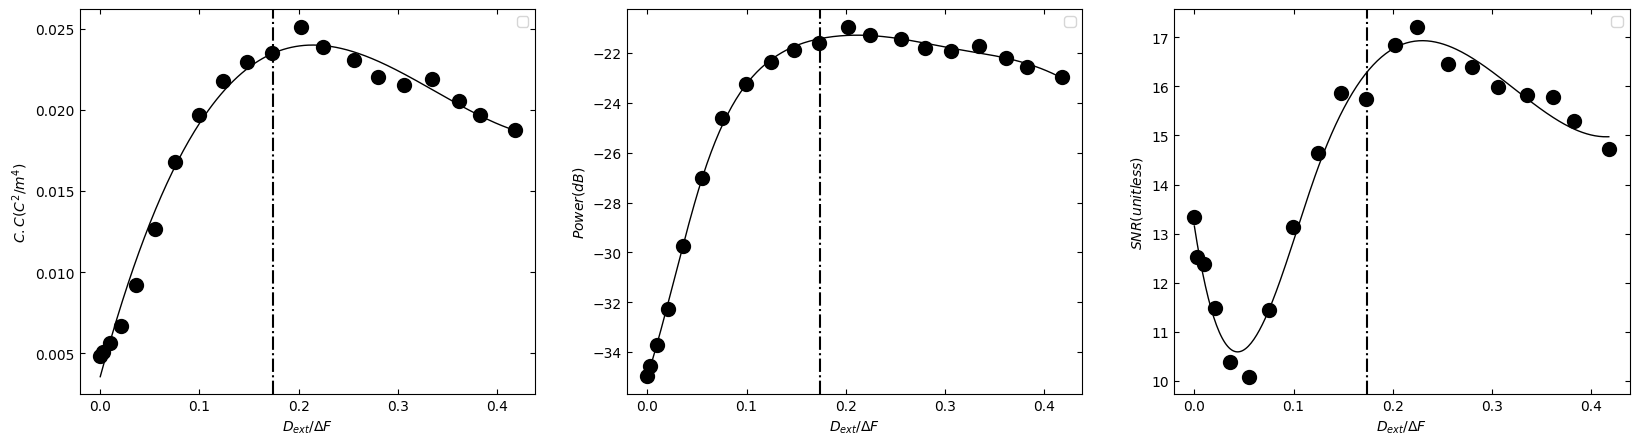

In [67]:
# Measurement only
lwth = 1
mwth = 2
ms = 9
clr = ["black"]
styl = ["o"]
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i])
plt.plot(Dext_delF_exp_smooth, cov_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms,  c = clr[i])
plt.plot(Dext_delF_exp_smooth, psr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i])
plt.plot(Dext_delF_exp_smooth, snr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

plt.savefig("fig//IITPKD_SR_metric_meas.pdf")


<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\3873314308.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\3873314308.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\3873314308.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignore

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


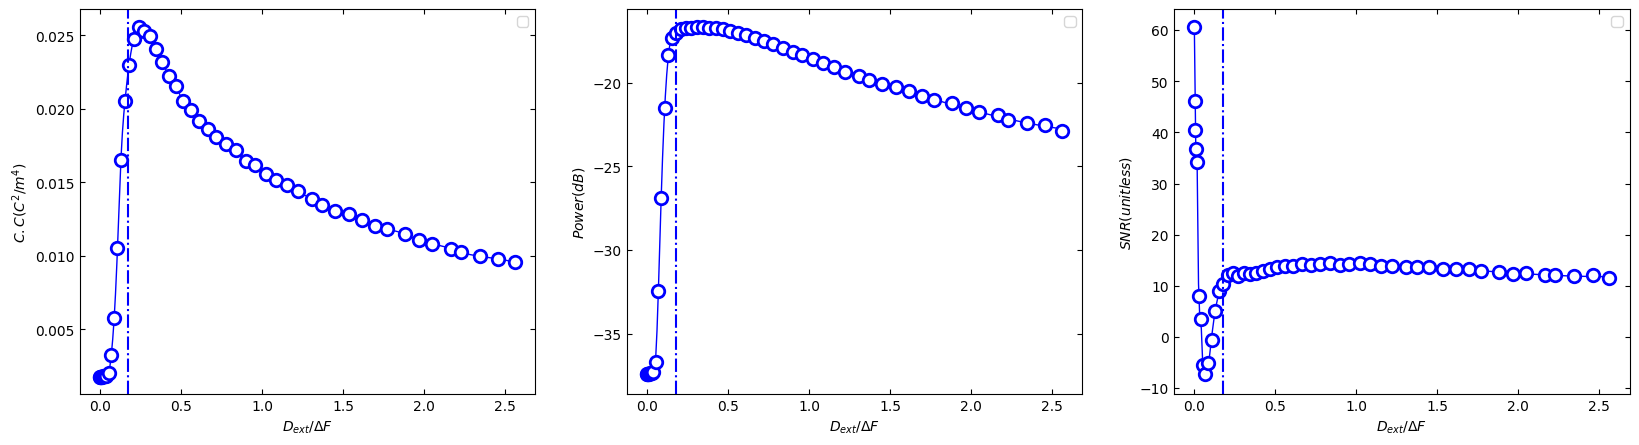

In [72]:
# Simulation only
lwth = 1
mwth = 2
ms = 9
clr = ["blue"]
styl = ["o"]
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(Dext_delF_smooth, cov_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, COV, styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2)
plt.plot(Dext_delF_smooth, psr_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, 10*np.log10(PSR), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white',  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3)
plt.plot(Dext_delF_smooth, snr_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, 10*np.log10(SNR), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

plt.savefig("fig//IITPKD_SR_metric_sim.pdf")


<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\2088196115.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\2088196115.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:

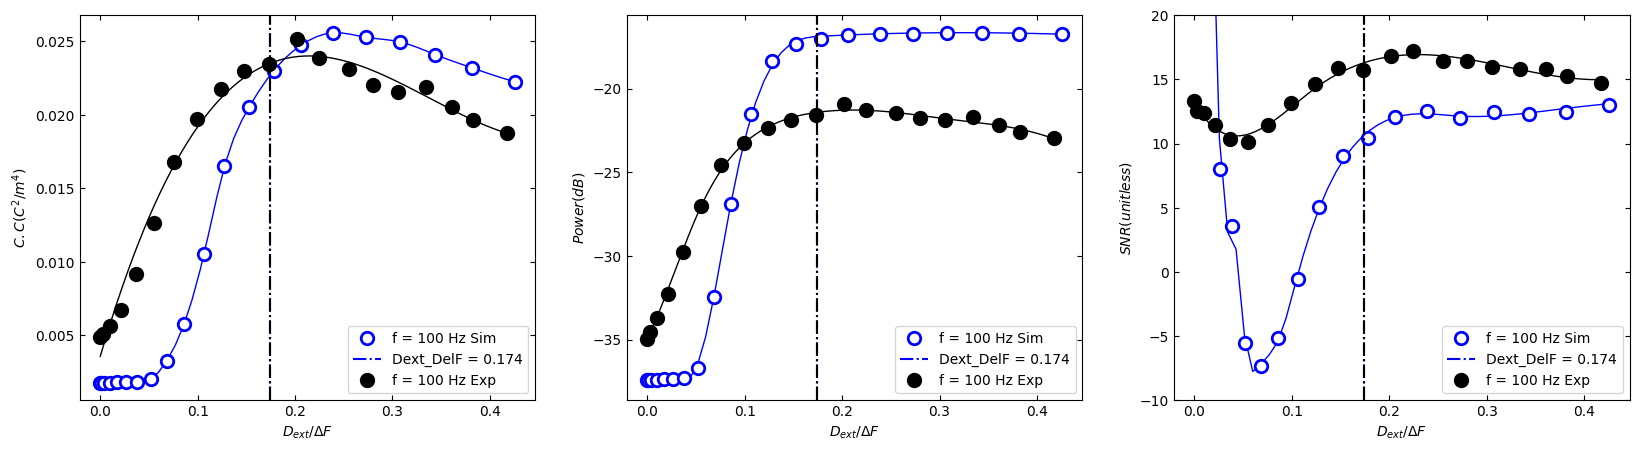

In [77]:
# Simulation vs Measurement
plt.figure(figsize=(20,5))

lwth = 1
mwth = 2
clr = ["blue"]
styl = ["o"]
to = 21
to1 = 50
plt.subplot(1,3,1)
plt.plot(Dext_delF_smooth[0:to1], cov_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], COV[0:to], styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2)
plt.plot(Dext_delF_smooth[0:to1], psr_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], 10*np.log10(PSR[0:to]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white',  c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3)
plt.plot(Dext_delF_smooth[0:to1], snr_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], 10*np.log10(SNR[0:to]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

lwth = 1
mwth = 2
clr = ["black"]
styl = ["o"]
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, cov_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms,  c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, psr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, snr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.ylim([-10,20])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.savefig("fig//IITPKD_SR_metric_simvsmeas_1.pdf")

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:61: SyntaxWarning: invalid escape sequence '\D'
<>:68: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:61: SyntaxWarning: invalid escape sequence '\D'
<>:68: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_12876\833908403.py:10: SyntaxWarning: 

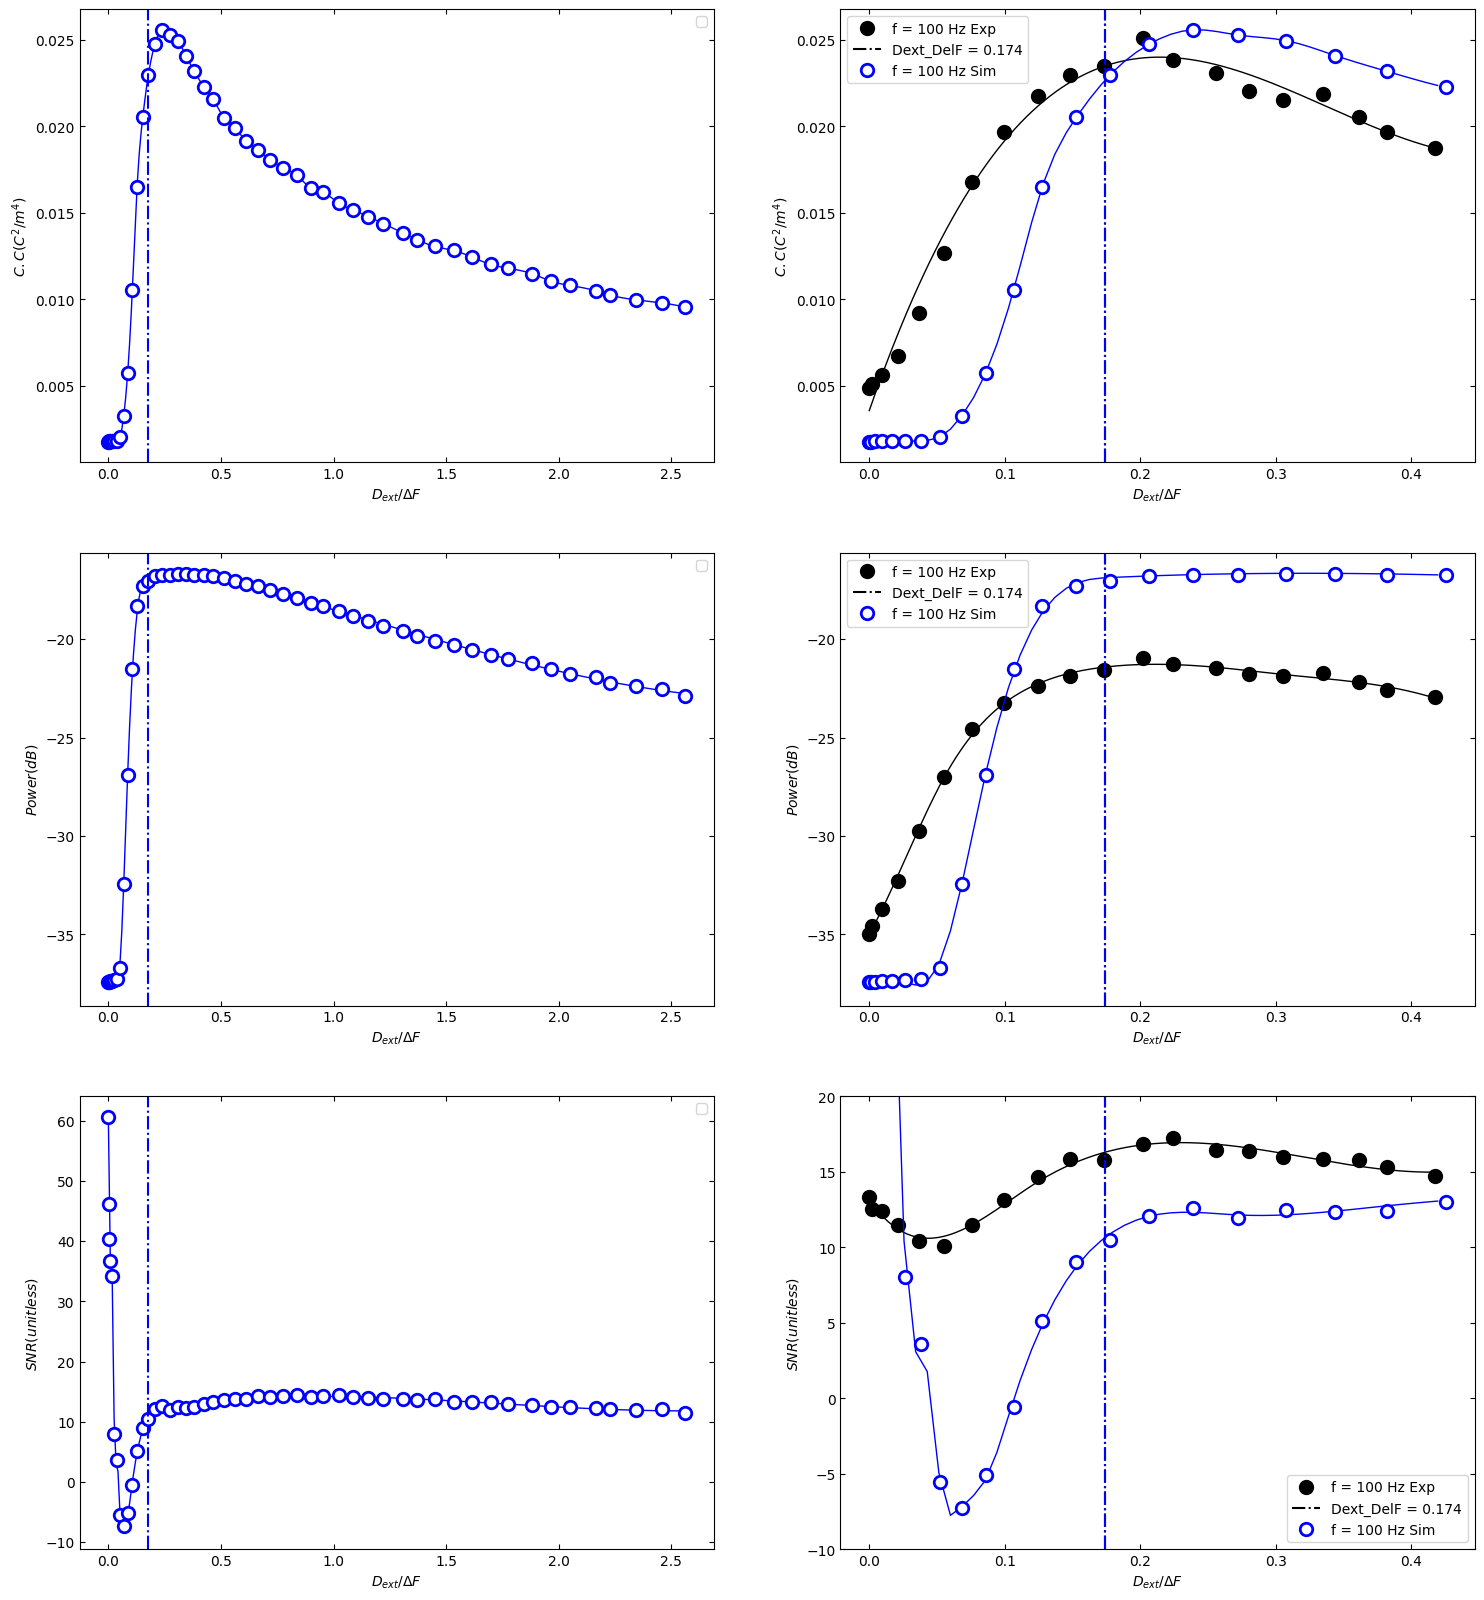

In [76]:
plt.figure(figsize=(18, 20))
lwth = 1
mwth = 2
ms = 9
clr = ["blue"]
styl = ["o"]
plt.subplot(3,2,1)
plt.plot(Dext_delF_smooth, cov_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, COV, styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,3)
plt.plot(Dext_delF_smooth, psr_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, 10*np.log10(PSR), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white',  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,5)
plt.plot(Dext_delF_smooth, snr_smooth, "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt, 10*np.log10(SNR), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

lwth = 1
mwth = 2
clr = ["black"]
styl = ["o"]
plt.subplot(3,2,2); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, cov_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,4); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms,  c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, psr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,6); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i], linewidth = lwth, mew = mwth, markersize=ms, c = clr[i], label = f"f = {f} Hz Exp")
plt.plot(Dext_delF_exp_smooth, snr_exp_smooth, "-", linewidth = lwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

lwth = 1
mwth = 2
clr = ["blue"]
styl = ["o"]
to = 21
to1 = 50
plt.subplot(3,2,2)
plt.plot(Dext_delF_smooth[0:to1], cov_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], COV[0:to], styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,4)
plt.plot(Dext_delF_smooth[0:to1], psr_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], 10*np.log10(PSR[0:to]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white',  c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,6)
plt.plot(Dext_delF_smooth[0:to1], snr_smooth[0:to1], "-", linewidth = lwth, c = clr[i])
plt.plot(Dext_delF_crt[0:to], 10*np.log10(SNR[0:to]), styl[i], linewidth = lwth, mew = mwth, markersize=ms, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.ylim([-10,20])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

plt.savefig("fig//IITPKD_SR_metric_simvsmeas_3.pdf")

### Time series plots

### Simulation vs Measurement 

Top Row SD = 0.18
Top Row SD = 0.8
Top Row SD = 1.96
Bottom Row SD = 0.2
Bottom Row SD = 1.0
Bottom Row SD = 4.0


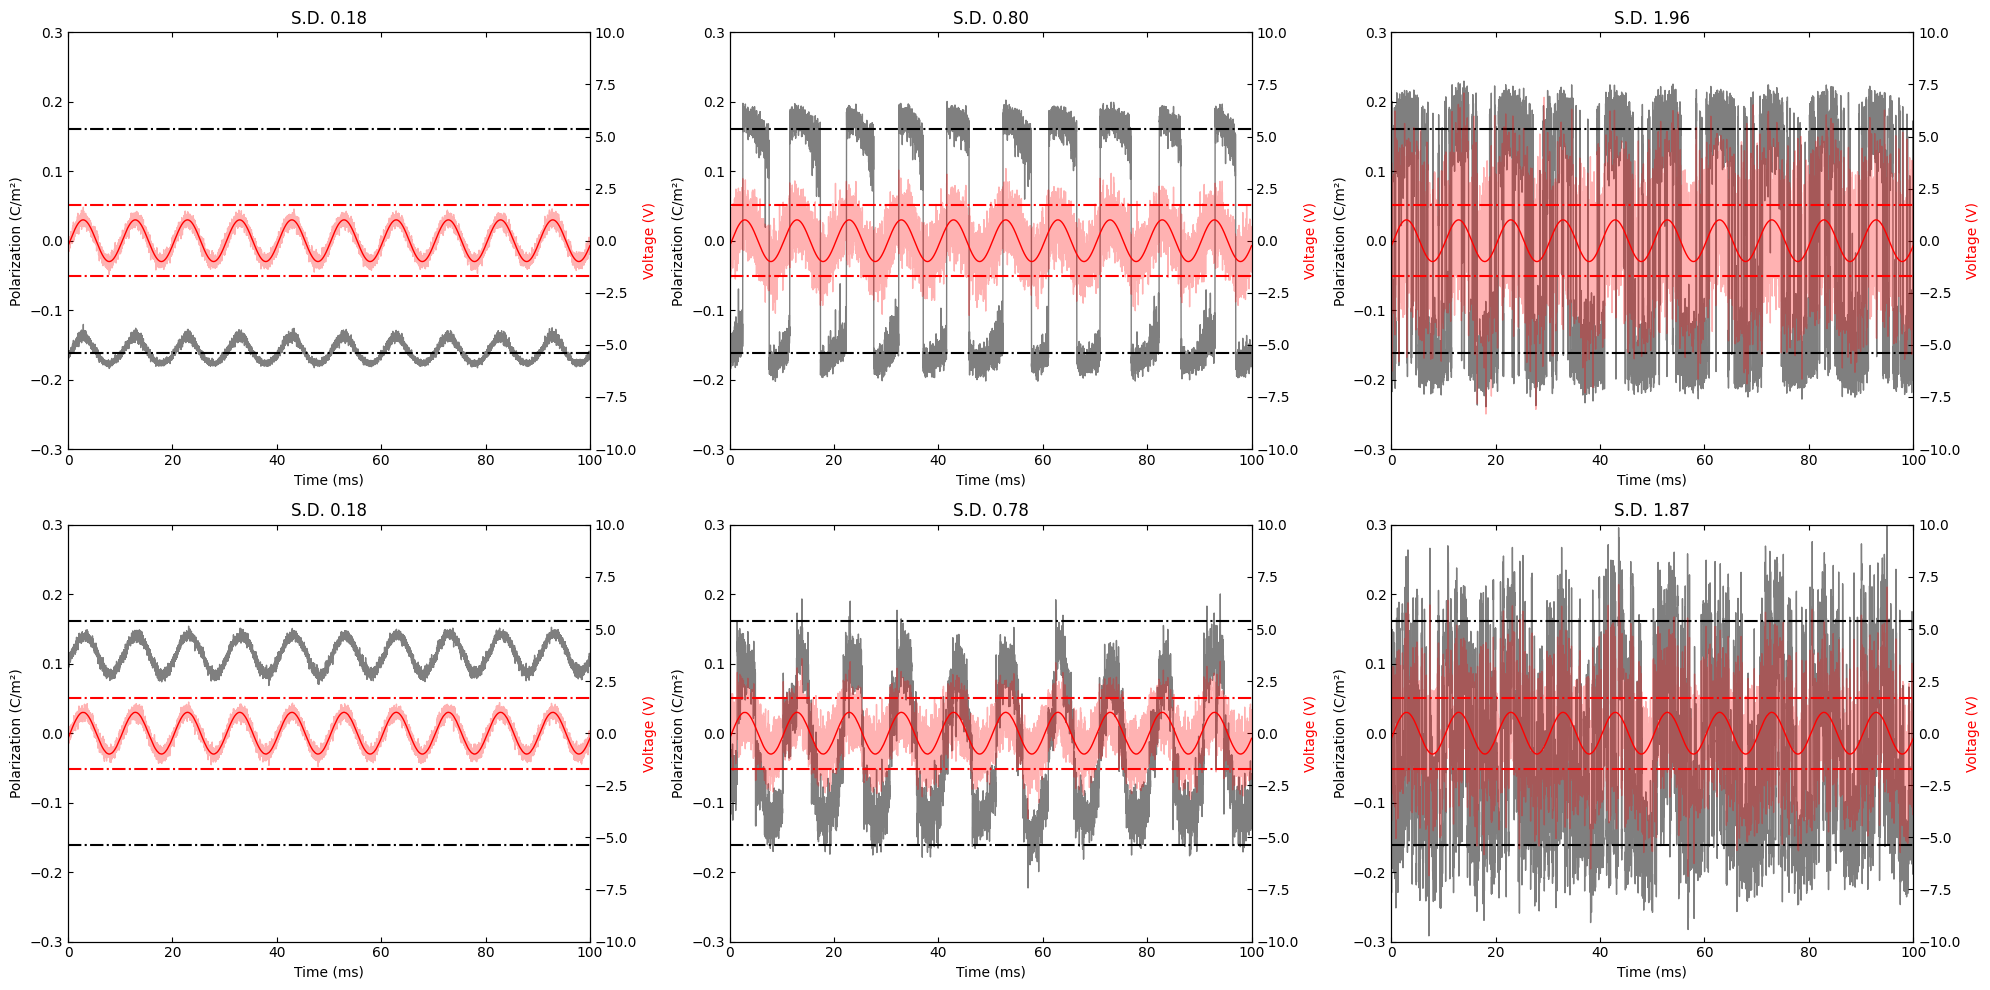

In [ ]:
sd_values_top = [0.18, 0.80, 1.96]
sd_values_bottom = [0.2, 1.0, 4.0]
clr = ["red", "black"]
lnwidth = [1,1]
alpha_P = 0.5
alpha_V = 0.3
dt_top = 1e-5
dt_bottom = 1e-5

fro1_top = 4960
fro1_bottom = 5160

no_cycle = 10

to1_top = int(fro1_top + no_cycle / (100 * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (100 * dt_bottom) + 1)

V_range = 10
P_range = 0.3

Vc = 1.7
Pr =  0.161


plt.figure(figsize=(20, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data_0, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    V_data_0 = V_data_0[fro1_top:to1_top] * tf

    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    
    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()


    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)

# for finding the corrected sd
fro = 250
t_data, V_data, P_data = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{0.0}_itr{0}.txt")
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    t_data, V_data, P_data = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd}_itr{0}.txt")
    t_data, V_data_0, _ = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{0.00}_itr{0}.txt")
    
    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0]) * 1e-3
    V_data = V_data[fro1_bottom:to1_bottom]
    V_data_0 = V_data_0[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)

    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)

plt.tight_layout()
# plt.savefig("fig//IITPKD_P_t_data_1.pdf")
plt.show()


Top Row SD = 0.18
Top Row SD = 0.8
Top Row SD = 1.96
Bottom Row SD = 0.2
Bottom Row SD = 1.0
Bottom Row SD = 4.0


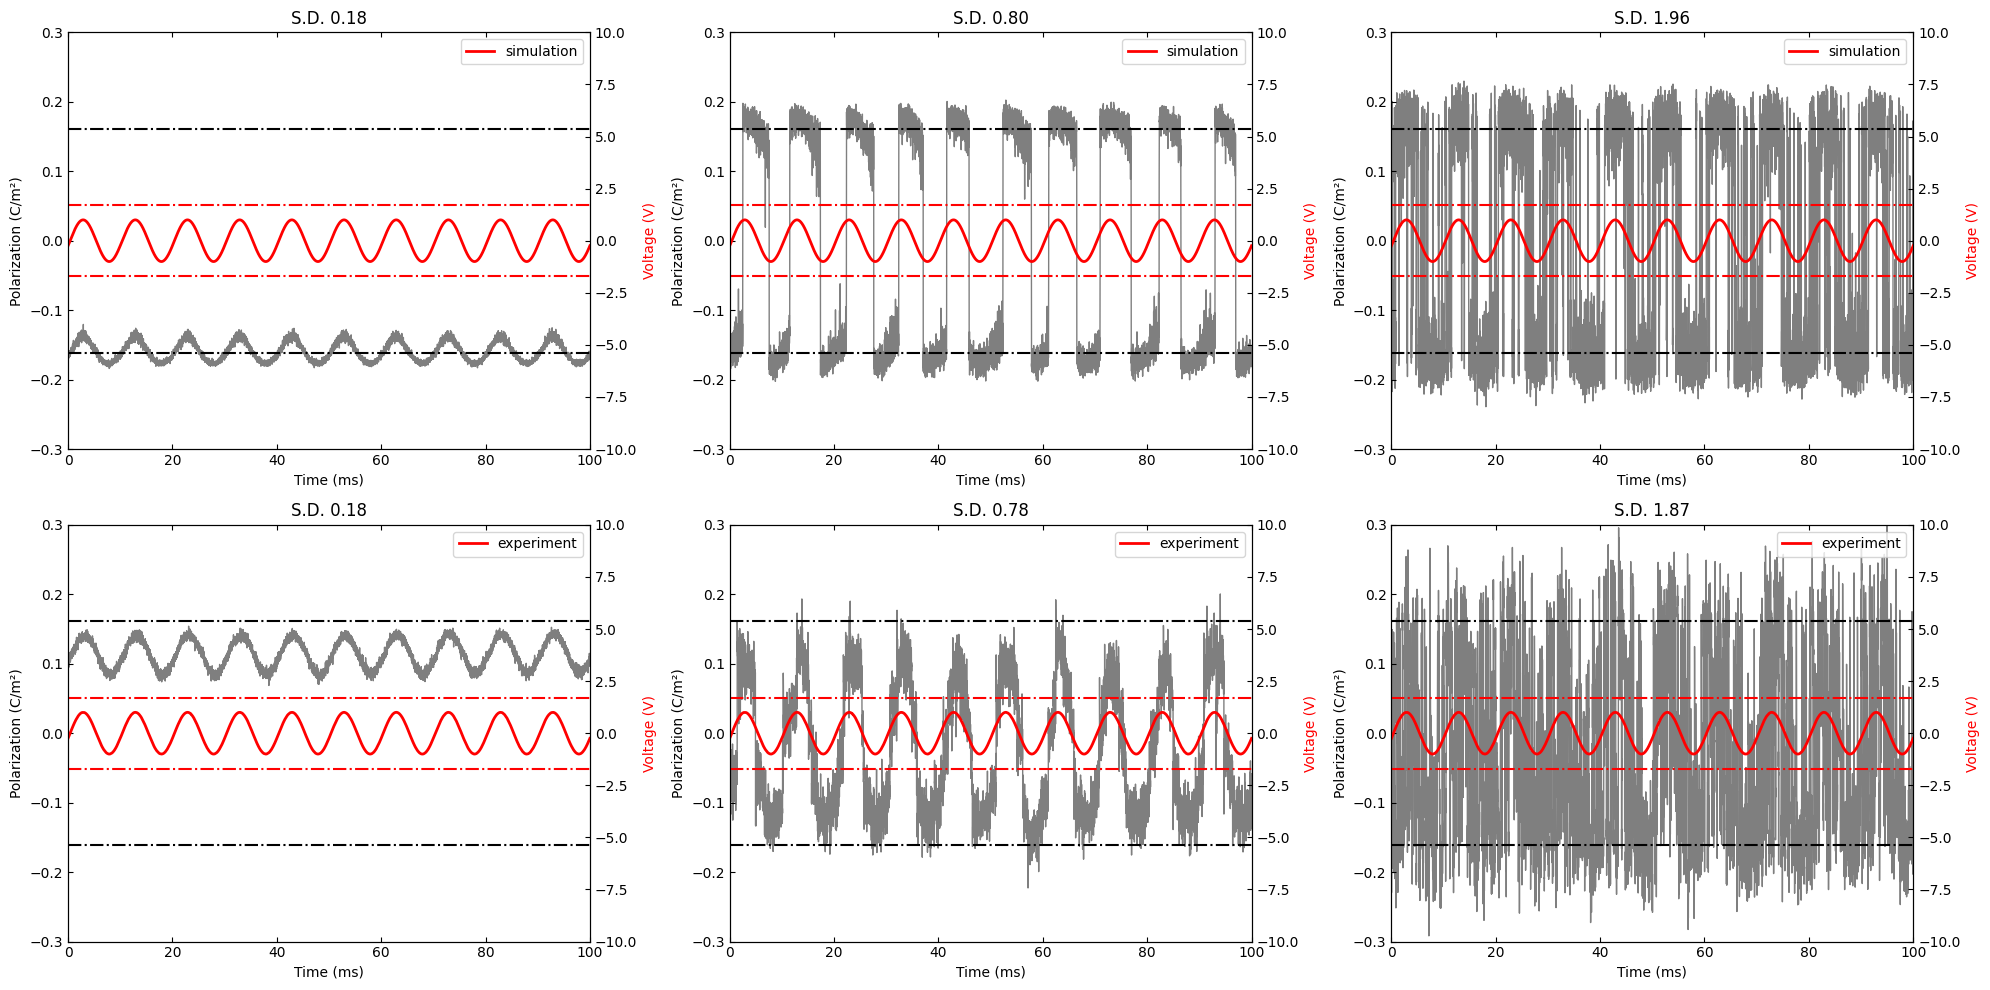

In [ ]:
sd_values_top = [0.18, 0.80, 1.96]
sd_values_bottom = [0.2, 1.0, 4.0]
clr = ["red", "black"]
lnwidth = [2,1]
alpha_P = 0.5
alpha_V = 1
dt_top = 1e-5
dt_bottom = 1e-5

fro1_top = 4960
fro1_bottom = 5160

no_cycle = 10

to1_top = int(fro1_top + no_cycle / (100 * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (100 * dt_bottom) + 1)

V_range = 10
P_range = 0.3

Vc = 1.7
Pr = 0.161


plt.figure(figsize=(20, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, _, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    
    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()


    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["simulation"])

# for finding the corrected sd
fro = 250
t_data, V_data, P_data = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{0.0}_itr{0}.txt")
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    t_data, _, P_data = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd}_itr{0}.txt")
    t_data, V_data, _ = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{0.00}_itr{0}.txt")
    t_data, V_data_i, _ = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd}_itr{0}.txt")
    
    sd_crt_plt =  sr.sd_correction(V_data_i[fro:],V0)
    # print(sd_crt_plt)
    dt = (t_data[1] - t_data[0]) * 1e-3
    V_data = V_data[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))*1e3
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)

    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.set_xlabel('Time (ms)')
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (ms)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["experiment"])

plt.tight_layout()
# plt.savefig("fig//IITPKD_P_t_data_2.pdf")
plt.show()
